In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [1]:
# find the timestamp of the experiment that has a matching CPU log entry
def find_first_matching_cpu_entry(cpu_log_file, experiment_folder):
    date_format = '%Y-%m-%d %H:%M:%S'
    cpu_df = pd.read_csv(cpu_log_file, header=None, names=['timestamp', 'memory', 'cpu'], skiprows=1)
    cpu_df['timestamp'] = pd.to_datetime(cpu_df['timestamp'], format=date_format)

    results = []

    for file_name in os.listdir(experiment_folder):
        file_path = os.path.join(experiment_folder, file_name)

        with open(file_path, 'r') as f:
            f.readline()
            line = f.readline().strip()
            experiment_timestamp_str = line.split(',')[0]
            experiment_timestamp = pd.to_datetime(experiment_timestamp_str, format='"%Y-%m-%d %H:%M:%S')

            matching_row = cpu_df[cpu_df['timestamp'] > experiment_timestamp].head(1)

            if not matching_row.empty:
                result = {
                    'experiment_file': file_name,
                    'experiment_timestamp': experiment_timestamp,
                    'cpu_log_row': matching_row.to_dict(orient='records')[0]
                }
                results.append(result)
    sorted_results = sorted(results, key=lambda x: x['experiment_timestamp'])
    return sorted_results

In [2]:
def calculate_averages(group_results, cpu_df):
    num_rows = 40
    averages_memory = [[] for _ in range(num_rows)]
    averages_cpu = [[] for _ in range(num_rows)]

    for result in group_results:
        matching_cpu_log_row = result['cpu_log_row']
        timestamp = matching_cpu_log_row['timestamp']
        cpu_df['timestamp'] = pd.to_datetime(cpu_df['timestamp'])
        start_index = cpu_df[cpu_df['timestamp'] == timestamp].index[0]
        end_index = start_index + num_rows
        rows = cpu_df.iloc[start_index:end_index]
        for i in range(num_rows):
            averages_memory[i].append(rows.iloc[i]['memory'])
            averages_cpu[i].append(rows.iloc[i]['cpu'])

    final_averages = []
    for i in range(num_rows):
        average_memory = sum(averages_memory[i]) / len(averages_memory[i])
        average_cpu = sum(averages_cpu[i]) / len(averages_cpu[i])

        final_averages.append({
            'row_index': i + 1,
            'average_memory': average_memory,
            'average_cpu': average_cpu
        })

    return final_averages

def get_average_cpu_memory(cpu_log_file, experiment_folder):
    group_size = 10
    sorted_results = find_first_matching_cpu_entry(cpu_log_file, experiment_folder)
    grouped_results = [sorted_results[i:i+group_size] for i in range(0, len(sorted_results), group_size)]
    final_results = []

    cpu_df = pd.read_csv(cpu_log_file, header=None, names=['timestamp', 'memory', 'cpu'], skiprows=1)
    for group in grouped_results:
        group_averages = calculate_averages(group, cpu_df)
        final_results.extend(group_averages)
    return final_results

In [3]:
# plot each granularity group as a line chart
def plot_cpu_memory(final_results):
    cpu_data = [item['average_cpu'] for item in final_results]
    memory_data = [item['average_memory'] for item in final_results]

    group_size = len(cpu_data) // 6
    cpu_groups = [cpu_data[i:i+group_size] for i in range(0, len(cpu_data), group_size)]
    memory_groups = [memory_data[i:i+group_size] for i in range(0, len(memory_data), group_size)]

    x = np.linspace(0, 120, group_size)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    #CPU line chart
    for i, group in enumerate(cpu_groups):
        ax1.plot(x, group, label=f'Group {i+1}')

    ax1.set_title('CPU Usage Over Time')
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Average CPU Usage')
    ax1.legend()

    #Memory line chart
    for i, group in enumerate(memory_groups):
         ax2.plot(x, group, label=f'Group {i+1}')

    ax2.set_title('Memory Usage Over Time')
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Average Memory Usage')
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [24]:
#aggregate the data points with different granularity
#load this at last
def plot_cpu_memory_with_granularity(cpu_log_file, points_to_combine, system_name, experiment_folder):
    final_results = get_average_cpu_memory(cpu_log_file, experiment_folder)
    output_cpu_memory_statistics(final_results, system_name)
    cpu_data = [item['average_cpu'] for item in final_results]
    memory_data = [item['average_memory'] for item in final_results]

    group_size = len(cpu_data) // 6
    cpu_groups = [cpu_data[i:i+group_size] for i in range(0, len(cpu_data), group_size)]
    memory_groups = [memory_data[i:i+group_size] for i in range(0, len(memory_data), group_size)]

    def combine_points(group, n):
        return [np.mean(group[i:i+n]) for i in range(0, len(group), n)]
    cpu_groups = [combine_points(group, points_to_combine) for group in cpu_groups]
    memory_groups = [combine_points(group, points_to_combine) for group in memory_groups]

    x = np.linspace(0, 120, len(cpu_groups[0]))
    fig, (ax2) = plt.subplots(1, 1, figsize=(12, 5))

    # Plot CPU data
    group_name = ['burst_high', 'burst_med', 'burst_low', 'even_high', 'even_med', 'even_low']

    # Plot memory data
    for i, group in enumerate(memory_groups):
        ax2.plot(x, group, label=group_name[i], marker='o')

    ax2.set_title(system_name + ' Memory Usage Over Time')
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Average Memory Usage')
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [5]:
# output the statistic of the CPU and memory usage
# load this fun first
def output_cpu_memory_statistics(final_results, system_name):
    cpu_data = [item['average_cpu'] for item in final_results]
    memory_data = [item['average_memory'] for item in final_results]

    group_size = len(cpu_data) // 6
    cpu_groups = [cpu_data[i:i+group_size] for i in range(0, len(cpu_data), group_size)]
    memory_groups = [memory_data[i:i+group_size] for i in range(0, len(memory_data), group_size)]
    group_name = ['burst_high', 'burst_med', 'burst_low', 'even_high', 'even_med', 'even_low']

    data = {'Group Name': group_name,
            'CPU Mean': [np.mean(group) for group in cpu_groups],
            'CPU Max': [np.max(group) for group in cpu_groups],
            'CPU Min': [np.min(group) for group in cpu_groups],
            'CPU STD': [np.std(group) for group in cpu_groups],
            'Memory Mean': [np.mean(group) for group in memory_groups],
            'Memory Max': [np.max(group) for group in memory_groups],
            'Memory Min': [np.min(group) for group in memory_groups],
            'Memory STD': [np.std(group) for group in memory_groups]}
    df = pd.DataFrame(data)
    pd.set_option('display.width', 1000)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)
    print(f'--------------------Statistics for {system_name} CPU and Memory Usage-----------------------')
    print(df)

--------------------Statistics for Pet System Fine Granularity CPU and Memory Usage-----------------------
   Group Name  CPU Mean  CPU Max  CPU Min   CPU STD  Memory Mean  Memory Max  Memory Min  Memory STD
0  burst_high   2.94450    34.43     0.75  6.058783     1.510575       1.513       1.507    0.001376
1   burst_med   1.38250     4.70     0.70  0.702456     1.535475       1.538       1.533    0.001628
2   burst_low   1.25975     2.49     0.74  0.414104     1.541175       1.543       1.539    0.000771
3   even_high   2.29400     3.36     1.12  0.498893     1.547625       1.550       1.546    0.000992
4    even_med   1.38750     2.34     0.87  0.347762     1.565200       1.567       1.563    0.001077
5    even_low   1.22775     1.92     0.79  0.256364     1.572100       1.574       1.571    0.000768


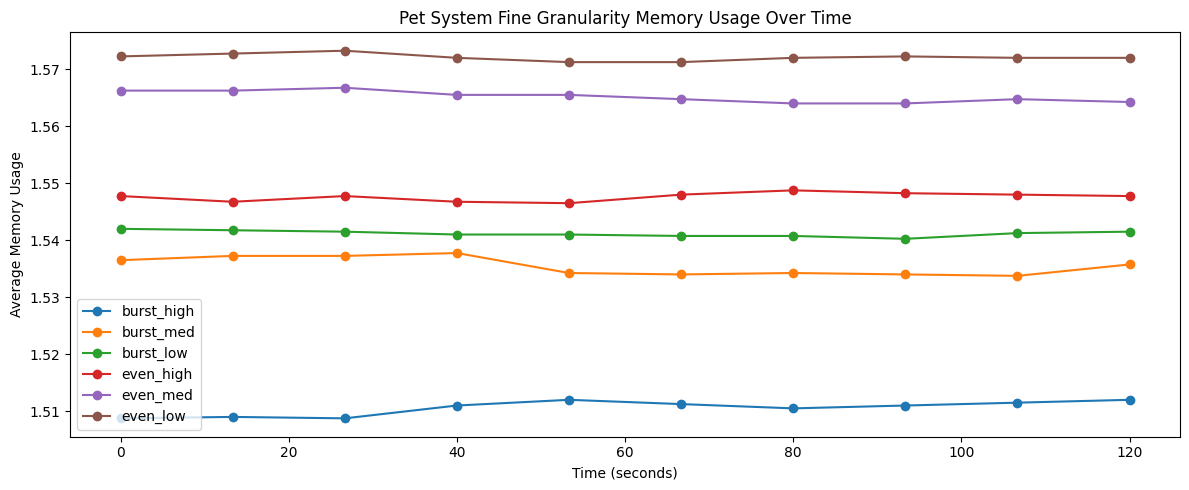

--------------------Statistics for Pet System Coarse Granularity CPU and Memory Usage-----------------------
   Group Name  CPU Mean  CPU Max  CPU Min   CPU STD  Memory Mean  Memory Max  Memory Min  Memory STD
0  burst_high   2.01825    20.21     0.60  3.393450     1.213550       1.215       1.212    0.001048
1   burst_med   1.16625     3.54     0.69  0.502547     1.251425       1.253       1.246    0.001498
2   burst_low   1.13975     2.13     0.63  0.384080     1.297025       1.299       1.296    0.000821
3   even_high   1.68850     8.53     0.70  1.785725     1.279150       1.282       1.276    0.001333
4    even_med   1.23100     2.69     0.68  0.427088     1.270050       1.272       1.268    0.000999
5    even_low   1.10650     1.86     0.65  0.294742     1.275225       1.277       1.274    0.000908


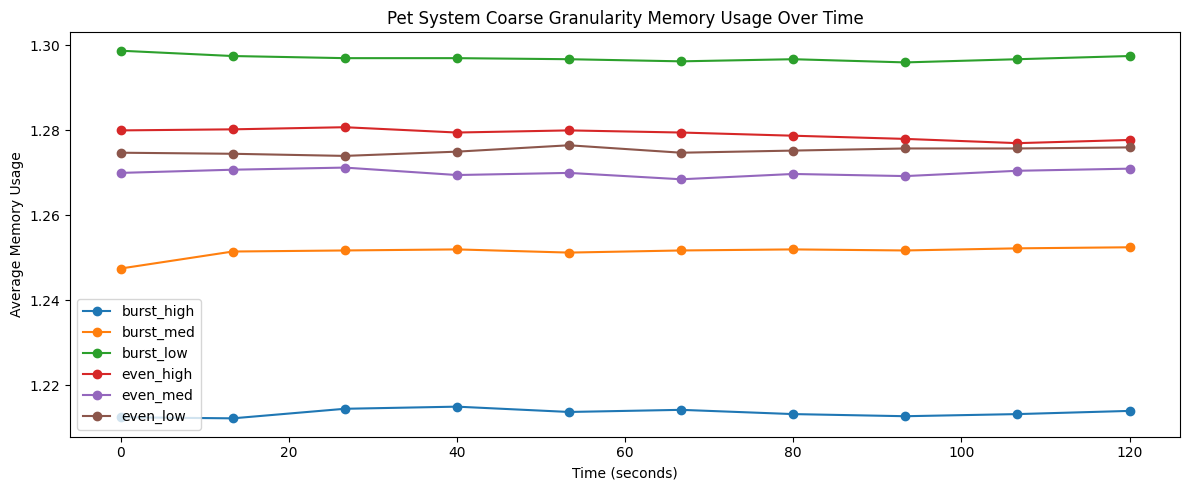

--------------------Statistics for Pet System Medium Granularity CPU and Memory Usage-----------------------
   Group Name  CPU Mean  CPU Max  CPU Min   CPU STD  Memory Mean  Memory Max  Memory Min  Memory STD
0  burst_high   2.66025    27.24     0.74  4.902168     1.318175       1.320       1.313    0.001464
1   burst_med   1.15350     4.67     0.59  0.688341     1.326250       1.328       1.324    0.000915
2   burst_low   1.18200     1.99     0.62  0.342061     1.323725       1.326       1.322    0.001072
3   even_high   1.83150     9.98     0.68  2.013177     1.336975       1.339       1.336    0.000790
4    even_med   1.11300     2.00     0.67  0.360896     1.342000       1.344       1.340    0.000922
5    even_low   1.19100     2.10     0.69  0.357399     1.342800       1.344       1.341    0.000714


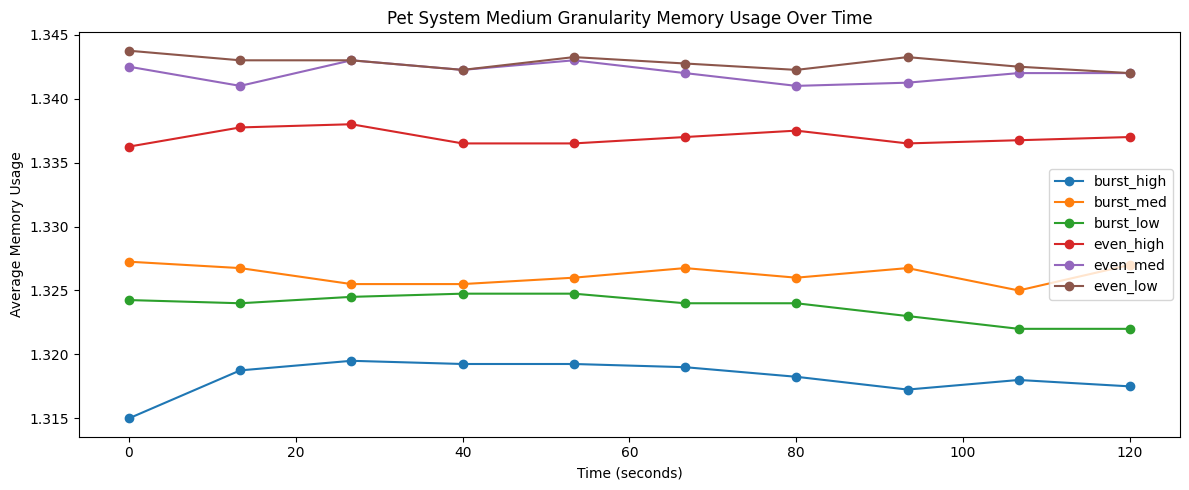

In [25]:
pet_fine_cpu = '../../result_f/pet/fine/cpu_mem_stats_20240728_180603.csv'
pet_fine_folder = '../pet_f/fine/'
pet_coarse_cpu = '../../result_f/pet/coarse/cpu_mem_stats_20240728_082507.csv'
pet_coarse_folder = '../pet_f/coarse/'
pet_medium_cpu = '../../result_f/pet/med/cpu_mem_stats_20240728_150504.csv'
pet_medium_folder = '../pet_f/med/'

#plot_cpu_memory(final_results)
points_to_combine = 4
plot_cpu_memory_with_granularity(pet_fine_cpu, points_to_combine, system_name = 'Pet System Fine Granularity', experiment_folder = pet_fine_folder)
plot_cpu_memory_with_granularity(pet_coarse_cpu, points_to_combine, system_name = 'Pet System Coarse Granularity', experiment_folder = pet_coarse_folder)
plot_cpu_memory_with_granularity(pet_medium_cpu, points_to_combine, system_name = 'Pet System Medium Granularity', experiment_folder = pet_medium_folder)

--------------------Statistics for Train System Fine Granularity CPU and Memory Usage-----------------------
   Group Name  CPU Mean  CPU Max  CPU Min    CPU STD  Memory Mean  Memory Max  Memory Min  Memory STD
0  burst_high   4.50975    62.87     1.01  12.091344     6.525550       6.530       6.513    0.002854
1   burst_med   1.80475    15.43     0.97   2.452191     6.514300       6.516       6.513    0.001122
2   burst_low   1.29850     2.07     0.92   0.250944     6.516400       6.518       6.516    0.000583
3   even_high   3.90500    10.72     1.02   3.491517     6.543750       6.549       6.533    0.004276
4    even_med   1.52600     3.95     0.97   0.596745     6.517350       6.518       6.517    0.000477
5    even_low   1.33750     3.26     1.05   0.349812     6.521025       6.523       6.520    0.000790


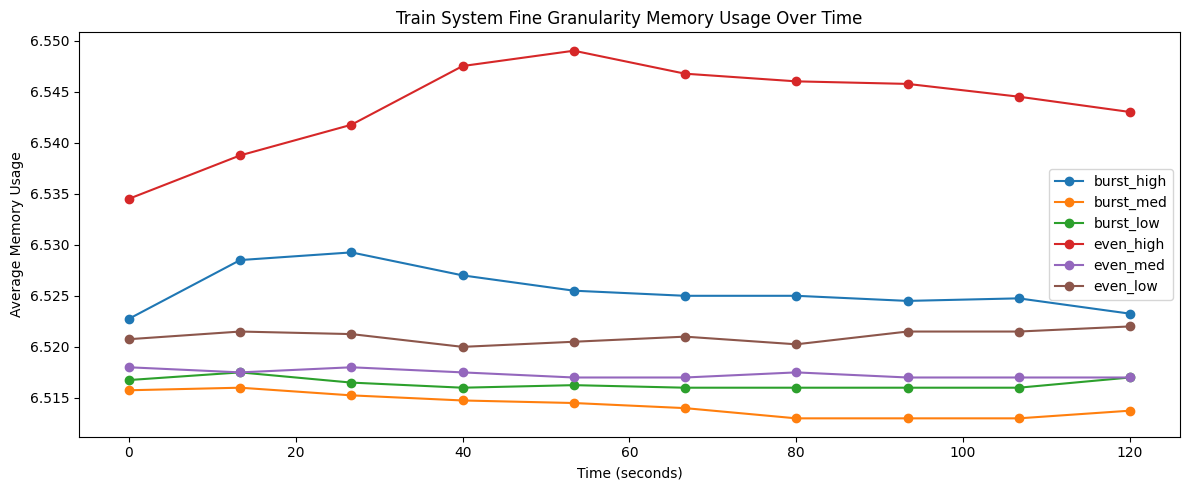

--------------------Statistics for Train System Coarse Granularity CPU and Memory Usage-----------------------
   Group Name  CPU Mean  CPU Max  CPU Min    CPU STD  Memory Mean  Memory Max  Memory Min  Memory STD
0  burst_high   4.13275    55.46     0.71  11.452431     2.451700       2.457       2.448    0.002326
1   burst_med   1.16675     6.98     0.74   1.033367     2.443950       2.445       2.442    0.000589
2   burst_low   0.96475     1.54     0.76   0.185027     2.448425       2.450       2.447    0.000738
3   even_high   3.03750     8.80     0.82   2.098817     2.427525       2.430       2.425    0.001884
4    even_med   1.12025     2.80     0.65   0.456369     2.430150       2.432       2.428    0.000937
5    even_low   0.97250     1.31     0.75   0.129262     2.437075       2.439       2.435    0.000685


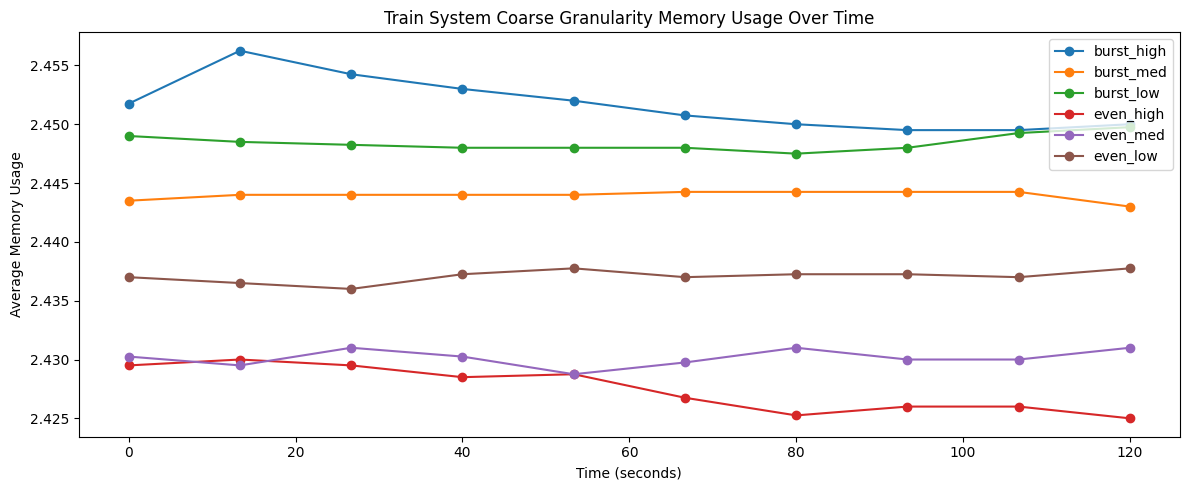

--------------------Statistics for Train System Medium Granularity CPU and Memory Usage-----------------------
   Group Name  CPU Mean  CPU Max  CPU Min    CPU STD  Memory Mean  Memory Max  Memory Min  Memory STD
0  burst_high   4.73725    62.80     0.83  13.471205     3.972800       3.975       3.964    0.002571
1   burst_med   1.26450     8.20     0.73   1.133232     3.974725       3.977       3.973    0.001024
2   burst_low   1.12475     2.28     0.79   0.272222     3.983500       3.984       3.983    0.000500
3   even_high   3.72200    12.06     0.78   3.556836     3.983550       3.986       3.981    0.001431
4    even_med   1.22950     3.39     0.88   0.533366     3.965450       3.967       3.964    0.000893
5    even_low   1.06750     1.96     0.82   0.202222     3.962275       3.966       3.961    0.001360


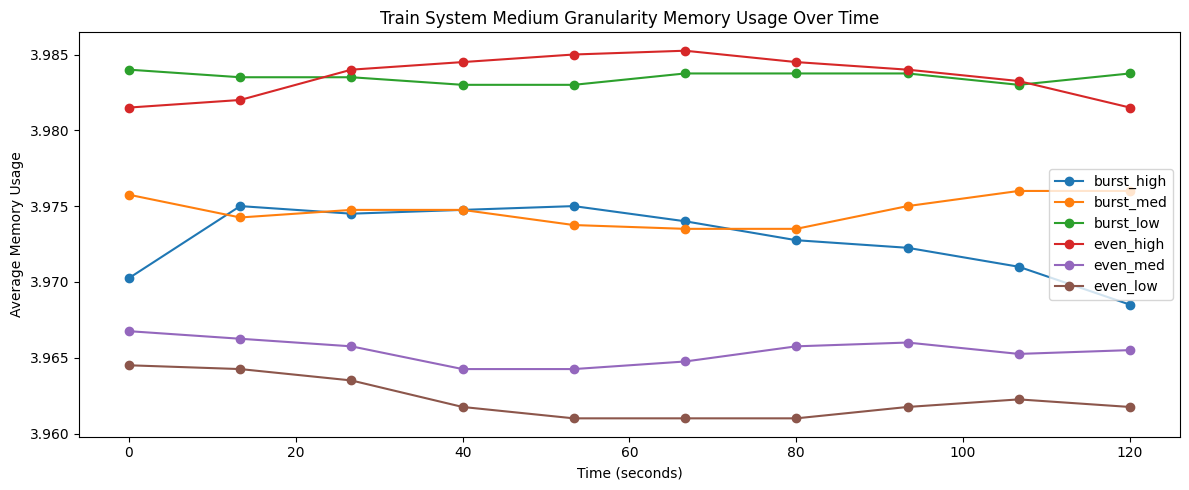

In [26]:
pet_fine_cpu = '../../result_f/train/fine/cpu_mem_stats_20240729_092632.csv'
pet_fine_folder = '../train_f/fine/'
pet_coarse_cpu = '../../result_f/train/coarse/cpu_mem_stats_20240729_160103.csv'
pet_coarse_folder = '../train_f/coarse/'
pet_medium_cpu = '../../result_f/train/med/cpu_mem_stats_20240729_124507.csv'
pet_medium_folder = '../train_f/med/'

#plot_cpu_memory(final_results)
points_to_combine = 4
plot_cpu_memory_with_granularity(pet_fine_cpu, points_to_combine, system_name = 'Train System Fine Granularity', experiment_folder = pet_fine_folder)
plot_cpu_memory_with_granularity(pet_coarse_cpu, points_to_combine, system_name = 'Train System Coarse Granularity', experiment_folder = pet_coarse_folder)
plot_cpu_memory_with_granularity(pet_medium_cpu, points_to_combine, system_name = 'Train System Medium Granularity', experiment_folder = pet_medium_folder)